# Description

It generates datasets showing different relationship types between pairs of variables (for instance, a linear or quadratic pattern) and then compares different correlation coefficients.

# Modules

In [48]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import minmax_scale
from pathlib import Path

from ccc import conf
from ccc.coef import ccc

In [49]:
import matplotlib

# matplotlib.rcParams['font.family'] = 'monospace'
matplotlib.rcParams["mathtext.fontset"] = "custom"
matplotlib.rcParams["mathtext.rm"] = "monospace"
matplotlib.rcParams["mathtext.it"] = "monospace:italic"
matplotlib.rcParams["mathtext.bf"] = "monospace:bold"

# Settings

In [50]:
PVALUE_N_PERMS = 10000
sns.set_context("poster")

# Paths

In [51]:
OUTPUT_FIGURE_DIR = Path("poster") / "intro"
OUTPUT_FIGURE_DIR.mkdir(parents=True, exist_ok=True)
display(OUTPUT_FIGURE_DIR)

PosixPath('poster/intro')

# Numerical datasets

## Anscombe dataset

In [52]:
datasets_df = sns.load_dataset("anscombe")

In [53]:
datasets_df.shape

(44, 3)

In [54]:
datasets_df.head()

,dataset,x,y
0,I,10.0,8.04
1,I,8.0,6.95
2,I,13.0,7.58
3,I,9.0,8.81
4,I,11.0,8.33


In [55]:
datasets_df = datasets_df.assign(
    dataset=datasets_df["dataset"].apply(lambda x: f"Anscombe {x}")
)

In [56]:
datasets_df.describe()

,x,y
count,44.000000,44.000000
mean,9.000000,7.500682
std,3.198837,1.958925
min,4.000000,3.100000
25%,7.000000,6.117500
50%,8.000000,7.520000
75%,11.000000,8.747500
max,19.000000,12.740000


In [57]:
x_lim = (3, 20)
y_lim = (3, 13)

## Quadratic

In [58]:
rel_name = "Quadratic"

In [59]:
np.random.seed(0)

x = minmax_scale(np.random.rand(100), (-10, 10))
y = np.power(x, 2.0)

x = minmax_scale(x, (0, x_lim[1]))
x = x + np.random.normal(0, 0.5, x.shape[0])
y = minmax_scale(y, y_lim)
y = y + np.random.normal(0, 0.5, y.shape[0])

datasets_df = datasets_df[~datasets_df["dataset"].isin((rel_name,))]
# datasets_df = datasets_df.append(
#     pd.DataFrame(
#         {
#             "dataset": rel_name,
#             "x": x,
#             "y": y,
#         }
#     ),
#     ignore_index=True,
# )
datasets_df = pd.concat(
    [
        datasets_df,
        pd.DataFrame({"dataset": rel_name, "x": x, "y": y}),
    ],
    ignore_index=True,
)

## Non-coexistence

In [60]:
rel_name = "Non-coexistence"

In [61]:
np.random.seed(5)

# x = minmax_scale(np.random.beta(0.5, 0.5, 50), (0.05, 20))
# y = np.power(0.05, x) # np.log(x) / np.log(1/10.)

x = minmax_scale(np.random.rand(50), (0, x_lim[1]))
y = minmax_scale(np.random.rand(50), (2, 2 + 0.5))

x2 = minmax_scale(np.random.rand(50), (0, 0 + 0.5))
y2 = minmax_scale(np.random.rand(50), (2, y_lim[1]))
x = np.append(x, x2)
y = np.append(y, y2)

# x = minmax_scale(x, (0, 20))
x = x + np.random.normal(0, 0.05, x.shape[0])
# y = minmax_scale(y, (3, 12))
y = y + np.random.normal(0, 0.05, y.shape[0])

datasets_df = datasets_df[~datasets_df["dataset"].isin((rel_name,))]
datasets_df = pd.concat(
    [
        datasets_df,
        pd.DataFrame({"dataset": rel_name, "x": x, "y": y}),
    ],
    ignore_index=True,
)

## Two-lines

In [62]:
rel_name = "Two-lines"

In [63]:
np.random.seed(5)

x = minmax_scale(np.random.rand(50), x_lim)
y = 0.3 * x

x2 = minmax_scale(np.random.rand(50), (0, 5))
y2 = 3.5 * x2
x = np.append(x, x2)
y = np.append(y, y2)

# x = minmax_scale(x, (0, 20))
x = x + np.random.normal(0, 0.5, x.shape[0])
y = minmax_scale(y, y_lim)
y = y + np.random.normal(0, 0.5, y.shape[0])

datasets_df = datasets_df[~datasets_df["dataset"].isin((rel_name,))]
datasets_df = pd.concat(
    [
        datasets_df,
        pd.DataFrame({"dataset": rel_name, "x": x, "y": y}),
    ],
    ignore_index=True,
)

## Random / independent

In [64]:
rel_name = "Random / independent"

In [65]:
np.random.seed(10)

x = np.random.rand(100)
y = np.random.rand(100)

x = minmax_scale(x, (0, x_lim[1]))
y = minmax_scale(y, y_lim)

datasets_df = datasets_df[~datasets_df["dataset"].isin((rel_name,))]
datasets_df = pd.concat(
    [
        datasets_df,
        pd.DataFrame({"dataset": rel_name, "x": x, "y": y}),
    ],
    ignore_index=True,
)

Create a dictionary with easier access to datasets

In [66]:
datasets = {
    idx: df.drop(columns="dataset") for idx, df in datasets_df.groupby("dataset")
}

## Create dataset dictionary

Create a dictionary with easier access to datasets

In [67]:
datasets = {
    idx: df.drop(columns="dataset") for idx, df in datasets_df.groupby("dataset")
}

## Plot

In [68]:
def get_cm_line_points(x, y, max_parts, parts):
    """
    Given two data vectors (x and y) and the max_parts and parts
    returned from calling cm, this function returns two arrays with
    scalars to draw the lines that separates clusters in x and y.
    """
    # get the ccc partitions that maximize the coefficient
    x_max_part = parts[0][max_parts[0]]
    x_unique_k = {}
    for k in np.unique(x_max_part):
        data = x[x_max_part == k]
        x_unique_k[k] = data.min(), data.max()
    x_unique_k = sorted(x_unique_k.items(), key=lambda x: x[1][0])

    y_max_part = parts[1][max_parts[1]]
    y_unique_k = {}
    for k in np.unique(y_max_part):
        data = y[y_max_part == k]
        y_unique_k[k] = data.min(), data.max()
    y_unique_k = sorted(y_unique_k.items(), key=lambda x: x[1][0])

    x_line_points, y_line_points = [], []

    for idx in range(len(x_unique_k) - 1):
        k, (k_min, k_max) = x_unique_k[idx]
        nk, (nk_min, nk_max) = x_unique_k[idx + 1]

        x_line_points.append((k_max + nk_min) / 2.0)

    for idx in range(len(y_unique_k) - 1):
        k, (k_min, k_max) = y_unique_k[idx]
        nk, (nk_min, nk_max) = y_unique_k[idx + 1]

        y_line_points.append((k_max + nk_min) / 2.0)

    return x_line_points, y_line_points

In [69]:
def pvalue_to_star(pvalue):
    s = "   "
    if pvalue < 0.001:
        s = "***"
    elif pvalue < 0.01:
        s = "** "
    elif pvalue < 0.05:
        s = "*  "

    return s

In [70]:
assert pvalue_to_star(0.06) == "   "
assert pvalue_to_star(0.04) == "*  "
assert pvalue_to_star(0.02) == "*  "
assert pvalue_to_star(0.01) == "*  "
assert pvalue_to_star(0.005) == "** "
assert pvalue_to_star(0.001) == "** "
assert pvalue_to_star(0.0001) == "***"

/home/haoyu/miniforge3/envs/ccc-gpu/lib/python3.10/site-packages/numpy/core/numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


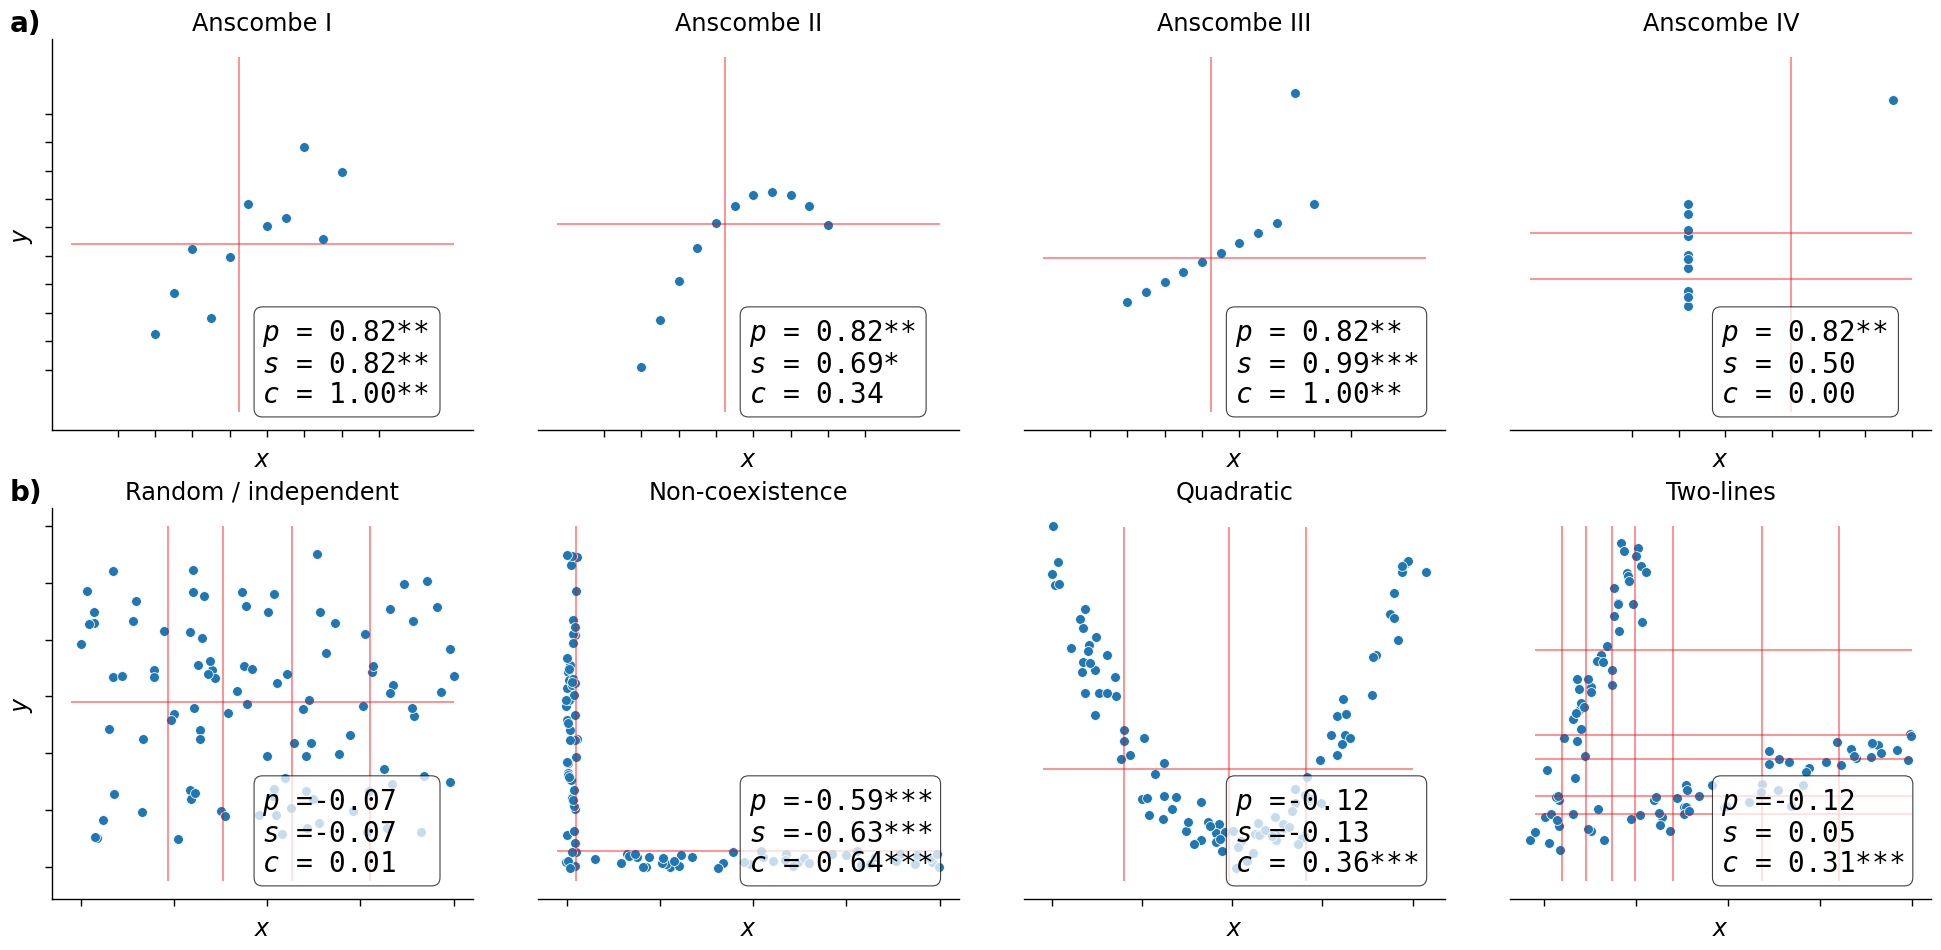

In [71]:
with sns.plotting_context("paper", font_scale=1.8):
    g = sns.FacetGrid(
        data=datasets_df,
        col="dataset",
        col_order=[
            "Anscombe I",
            "Anscombe II",
            "Anscombe III",
            "Anscombe IV",
            "Random / independent",
            "Non-coexistence",
            "Quadratic",
            "Two-lines",
        ],
        col_wrap=4,
        height=5,
        sharey=False,
        sharex=False,
    )
    g.map(sns.scatterplot, "x", "y", s=50, alpha=1)
    g.set_titles(row_template="{row_name}", col_template="{col_name}")
    g.set_xticklabels([])
    g.set_yticklabels([])

    for ax_idx, ax in enumerate(g.axes):
        ax.set_xlabel("$x$")

        if ax_idx == 0:
            ax.text(
                -0.10,
                1.02,
                "a)",
                fontweight="semibold",
                fontsize=20,
                transform=ax.transAxes,
                horizontalalignment="left",
            )
        elif ax_idx == 4:
            ax.text(
                -0.10,
                1.02,
                "b)",
                fontweight="semibold",
                fontsize=20,
                transform=ax.transAxes,
                horizontalalignment="left",
            )

        if ax_idx in (0, 4):
            ax.set_ylabel("$y$")
            continue

        sns.despine(ax=ax, left=True)
        ax.yaxis.set_tick_params(left=False)

    mono = {"family": "monospace"}

    for ds, ax in g.axes_dict.items():
        df = datasets[ds].to_numpy()
        x, y = df[:, 0], df[:, 1]

        # pearson and spearman
        r, r_p = pearsonr(x, y)
        rs, rs_p = spearmanr(x, y)

        # ccc
        (c, c_p), max_parts, parts = ccc(
            x, y, return_parts=True, pvalue_n_perms=PVALUE_N_PERMS
        )

        x_line_points, y_line_points = get_cm_line_points(x, y, max_parts, parts)
        for yp in y_line_points:
            ax.hlines(y=yp, xmin=-0.5, xmax=20, color="r", alpha=0.5)

        for xp in x_line_points:
            ax.vlines(x=xp, ymin=1.5, ymax=14, color="r", alpha=0.5)

        # add text box for the statistics
        stats = (
            f"$\it{{p}}$ ={r: .2f}{pvalue_to_star(r_p)}\n"
            f"$\it{{s}}$ ={rs: .2f}{pvalue_to_star(rs_p)}\n"
            f"$\it{{c}}$ ={c: .2f}{pvalue_to_star(c_p)}"
        )
        bbox = dict(boxstyle="round", fc="white", ec="black", alpha=0.75)
        ax.text(
            0.50,
            0.07,
            stats,
            fontsize=20,
            fontdict=mono,
            bbox=bbox,
            transform=ax.transAxes,
            horizontalalignment="left",
            linespacing=1.1,
        )

    plt.subplots_adjust(hspace=0.2)

    plt.savefig(
        OUTPUT_FIGURE_DIR / "numerical_relationships.svg",
        # rasterized=True,
        # dpi=300,
        bbox_inches="tight",
        facecolor="white",
    )

**Takeaways**:

A more detailed explanation of this figure is present in this PR: https://github.com/greenelab/ccc-manuscript/pull/3

Some points:

1. When the number of internal clusters (separated by red lines) is higher, CCC is able to capture more complex relationships.
1. With two internal clusters (Anscombe I, II and III) for each variable pair, CCC seems to capture linear relationships. However, two clusters also capture non-coexistence relationships.

# Categorical datasets

## Independent Two-Categorical

In [72]:
rel_name = "Two-Categorical I"

In [73]:
np.random.seed(4)

x = np.random.choice(["A", "B", "C"], 100)
y = np.random.choice(["Orange", "Blue"], 100)

cat_datasets_df = pd.DataFrame(
    {
        "dataset": rel_name,
        "x": x,
        "y": y,
    }
)

## Two-Categorical

In [74]:
rel_name = "Two-Categorical II"

In [75]:
np.random.seed(0)

x = np.random.choice(["A", "B", "C"], 100)
y = np.random.choice(["Orange", "Blue"], 100)

_df = pd.DataFrame(
    {
        "dataset": rel_name,
        "x": x,
        "y": y,
    }
)

_df.loc[_df[_df["x"] == "A"].sample(frac=0.50).index, "y"] = "Blue"
_df.loc[_df[_df["x"] == "B"].sample(frac=0.75).index, "y"] = "Orange"

cat_datasets_df = cat_datasets_df[~cat_datasets_df["dataset"].isin((rel_name,))]
# cat_datasets_df = cat_datasets_df.append(
#     _df,
#     ignore_index=True,
# )
cat_datasets_df = pd.concat(
    [
        cat_datasets_df,
        _df,
    ],
    ignore_index=True,
)

## Independent Two-Categorical-One-Numerical

In [76]:
rel_name = "Categorical-Numerical I"

In [77]:
np.random.seed(10)

x = np.random.choice(["A", "B", "C"], 100)
y = np.random.rand(100)
y = minmax_scale(y, y_lim)

cat_datasets_df = cat_datasets_df[~cat_datasets_df["dataset"].isin((rel_name,))]
# cat_datasets_df = cat_datasets_df.append(
#     pd.DataFrame(
#         {
#             "dataset": rel_name,
#             "x": x,
#             "y": y,
#         }
#     ),
#     ignore_index=True,
# )
cat_datasets_df = pd.concat(
    [
        cat_datasets_df,
        pd.DataFrame({"dataset": rel_name, "x": x, "y": y}),
    ],
    ignore_index=True,
)

## Two-Categorical-One-Numerical

In [78]:
rel_name = "Categorical-Numerical II"

In [79]:
np.random.seed(0)

x = np.random.choice(["A", "B", "C"], 100)
y = np.nan

_df = pd.DataFrame(
    {
        "dataset": rel_name,
        "x": x,
        "y": y,
    }
)

_idx = _df[_df["x"] == "A"].index  # .sample(frac=0.50).index
_df.loc[_idx, "y"] = np.random.normal(0, 0.50, _idx.shape[0])

_idx = _df[_df["x"] == "B"].index  # sample(frac=0.75).index
_df.loc[_idx, "y"] = np.random.normal(1, 0.25, _idx.shape[0])

_idx = _df[_df["x"] == "C"].index  # sample(frac=0.75).index
_df.loc[_idx, "y"] = np.random.normal(1, 0.75, _idx.shape[0])

_df["y"] = minmax_scale(_df["y"], y_lim)

# _idx = _df[_df["x"] == "B"].sample(frac=0.75).index
# _df.loc[_idx, "y"] = np.random.normal(0, 1, _idx.shape[0])

cat_datasets_df = cat_datasets_df[~cat_datasets_df["dataset"].isin((rel_name,))]
# cat_datasets_df = cat_datasets_df.append(
#     _df,
#     ignore_index=True,
# )
cat_datasets_df = pd.concat(
    [
        cat_datasets_df,
        _df,
    ],
    ignore_index=True,
)

## Create dataset dictionary

Create a dictionary with easier access to datasets

In [80]:
categorical_datasets = {
    idx: df.drop(columns="dataset") for idx, df in cat_datasets_df.groupby("dataset")
}

## Plot

In [81]:
cat_datasets_df

,dataset,x,y
0,Two-Categorical I,C,Orange
1,Two-Categorical I,C,Orange
2,Two-Categorical I,B,Blue
3,Two-Categorical I,B,Blue
4,Two-Categorical I,A,Blue
...,...,...,...
395,Categorical-Numerical II,A,7.029552
396,Categorical-Numerical II,C,10.915389
397,Categorical-Numerical II,A,8.293415
398,Categorical-Numerical II,B,9.111649


In [82]:
def get_cm_line_points(y, max_parts, parts):
    """
    Similar to previous function definition of same name, but only takes one variable.
    """
    y_max_part = parts[1][max_parts[1]]
    y_unique_k = {}
    for k in np.unique(y_max_part):
        data = y[y_max_part == k]
        y_unique_k[k] = data.min(), data.max()
    y_unique_k = sorted(y_unique_k.items(), key=lambda x: x[1][0])

    # x_line_points, y_line_points = [], []
    y_line_points = []

    for idx in range(len(y_unique_k) - 1):
        k, (k_min, k_max) = y_unique_k[idx]
        nk, (nk_min, nk_max) = y_unique_k[idx + 1]

        y_line_points.append((k_max + nk_min) / 2.0)

    return y_line_points

In [83]:
def plot_internal(x, y, **kwargs):
    x = pd.to_numeric(x, errors="ignore")
    y = pd.to_numeric(y, errors="ignore")
    x_is_num = pd.api.types.is_numeric_dtype(x.dtype)
    y_is_num = pd.api.types.is_numeric_dtype(y.dtype)
    if not x_is_num and not y_is_num:
        sns.countplot(x=x, hue=y, order=["A", "B", "C"], hue_order=["Blue", "Orange"])
    elif not x_is_num and y_is_num:
        # Bug: Missing hue parameter for categorical-numerical plots
        # Original: sns.swarmplot(x=x, y=y, order=["A", "B", "C"])
        # Corrected:
        if "hue" in kwargs:
            sns.swarmplot(x=x, y=y, hue=kwargs["hue"], order=["A", "B", "C"])
        else:
            # If no hue is provided in the dataset, at least maintain color distinction
            sns.swarmplot(x=x, y=y, order=["A", "B", "C"], palette="Set1")

/tmp/ipykernel_2557612/1639212968.py:2: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  x = pd.to_numeric(x, errors="ignore")
/tmp/ipykernel_2557612/1639212968.py:3: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  y = pd.to_numeric(y, errors="ignore")
/tmp/ipykernel_2557612/1639212968.py:2: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  x = pd.to_numeric(x, errors="ignore")
/tmp/ipykernel_2557612/1639212968.py:3: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  y = pd.to_numeric(y, errors="ignore")
/tmp/ipykernel_2557612/1639212968.py

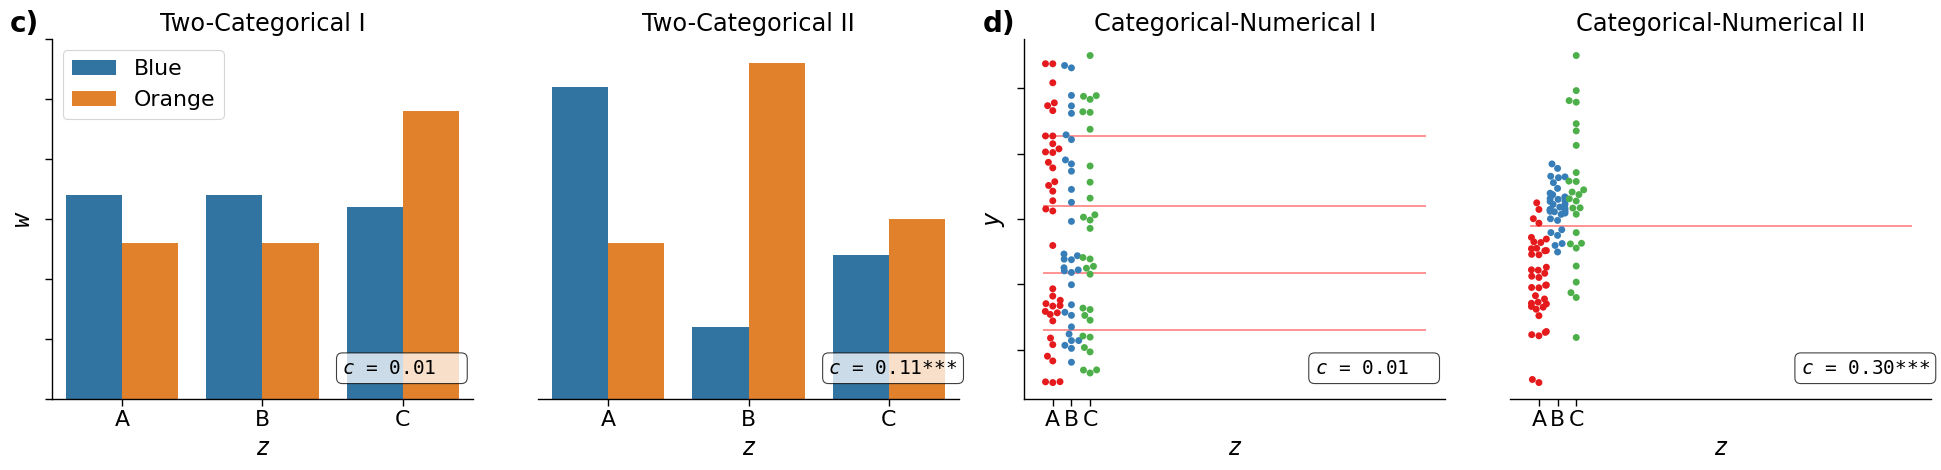

In [84]:
with sns.plotting_context("paper", font_scale=1.8):
    g = sns.FacetGrid(
        data=cat_datasets_df,
        col="dataset",
        col_order=[
            "Two-Categorical I",
            "Two-Categorical II",
            "Categorical-Numerical I",
            "Categorical-Numerical II",
        ],
        col_wrap=4,
        height=5,
        legend_out=False,
        sharex=False,
        sharey=False,
    )
    g.map(plot_internal, "x", "y", s=1, alpha=1)
    g.set_titles(row_template="{row_name}", col_template="{col_name}")
    g.add_legend()
    # g.set_xticklabels([])
    g.set_yticklabels([])

    for ax_idx, ax in enumerate(g.axes):
        if ax_idx in (1, 3):
            sns.despine(ax=ax, left=True)
            ax.yaxis.set_tick_params(left=False)

        if ax_idx in (0,):
            ax.set(ylabel="$w$", xlabel="$z$")

            ax.text(
                -0.10,
                1.02,
                "c)",
                fontweight="semibold",
                fontsize=20,
                transform=ax.transAxes,
                horizontalalignment="left",
            )

        if ax_idx in (1,):
            ax.set(xlabel="$z$")

        if ax_idx in (2,):
            ax.set(ylabel="$y$", xlabel="$z$")

            ax.text(
                -0.10,
                1.02,
                "d)",
                fontweight="semibold",
                fontsize=20,
                transform=ax.transAxes,
                horizontalalignment="left",
            )

        if ax_idx in (3,):
            ax.set(xlabel="$z$")

    mono = {"family": "monospace"}

    for ds, ax in g.axes_dict.items():
        df = categorical_datasets[ds]
        x, y = df["x"], df["y"]
        x = pd.to_numeric(x, errors="ignore").to_numpy()
        y = pd.to_numeric(y, errors="ignore").to_numpy()

        x_is_num = pd.api.types.is_numeric_dtype(x.dtype)
        y_is_num = pd.api.types.is_numeric_dtype(y.dtype)

        # ccc
        (c, c_p), max_parts, parts = ccc(
            x, y, return_parts=True, pvalue_n_perms=PVALUE_N_PERMS
        )

        if y_is_num:
            y_line_points = get_cm_line_points(y, max_parts, parts)
            for yp in y_line_points:
                ax.hlines(y=yp, xmin=-0.5, xmax=20, color="r", alpha=0.5)

        # add text box for the statistics
        stats = f"$\it{{c}}$ ={c: .2f}{pvalue_to_star(c_p)}"
        bbox = dict(boxstyle="round", fc="white", ec="black", alpha=0.75)
        ax.text(
            0.69,
            0.07,
            stats,
            fontsize=14,
            fontdict=mono,
            bbox=bbox,
            transform=ax.transAxes,
            horizontalalignment="left",
            linespacing=1.1,
        )

    plt.savefig(
        OUTPUT_FIGURE_DIR / "categorical_relationships.svg",
        # rasterized=True,
        # dpi=300,
        bbox_inches="tight",
        facecolor="white",
    )

# Create final figure

In [85]:
from svgutils.compose import Figure, SVG, Panel

ModuleNotFoundError: No module named 'svgutils'

In [40]:
Figure(
    "8.0cm",
    "6.5cm",
    Panel(
        SVG(OUTPUT_FIGURE_DIR / "numerical_relationships.svg").scale(0.005),
    ),
    Panel(
        SVG(OUTPUT_FIGURE_DIR / "categorical_relationships.svg").scale(0.005),
    ).move(0, 3.45),
).save(OUTPUT_FIGURE_DIR / f"relationships.svg")

Now open the file, reside to fit drawing to page, and add a white rectangle to the background.